In [60]:
# Reference - https://www.datacamp.com/community/tutorials/lstm-python-stock-market
# Make sure that you have all these libaries available to run the code successfully
from pandas_datareader import data
import matplotlib.pyplot as plt
import pandas as pd
import datetime as dt
import urllib.request, json 
import os
import numpy as np
import tensorflow as tf # This code has been tested with TensorFlow 1.6
from sklearn.preprocessing import MinMaxScaler
# Train & Test data split
from sklearn.model_selection import train_test_split

In [61]:
# Set home directory
os.chdir('C:\\Users\\S719789\\Desktop\\Data Science\\Random Learnings\\LSTM-Stock movement prediction\\price-volume-data-for-all-us-stocks-etfs\\Data')


In [75]:
# Loading data
data_source = 'kaggle' # alphavantage or kaggle  -- Using alphavantage

if data_source == 'alphavantage':
    # ====================== Loading Data from Alpha Vantage ==================================

    api_key = '62A3P9S4FUCU3SA5' 

    # American Airlines stock market prices
    ticker = "AAL" 

    # JSON file with all the stock market data for AAL within the last 20 years
    url_string = "https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol=%s&outputsize=full&apikey=%s"%(ticker,api_key)

    # Save data to this file
    file_to_save = 'stock_market_data-%s.csv'%ticker

    # If you haven't already saved data,
    # Go ahead and grab the data from the url
    # And store date, low, high, volume, close, open values to a Pandas dataframe
    if not os.path.exists(file_to_save):
        with urllib.request.urlopen(url_string) as url:
            data = json.loads(url.read().decode())
            # extract stock market data
            data = data['Time Series (Daily)']
            df = pd.DataFrame(columns=['Date','Low','High','Close','Open'])
            for k,v in data.items():
                date = dt.datetime.strptime(k, '%Y-%m-%d')
                data_row = [date.date(),float(v['3. low']),float(v['2. high']),
                            float(v['4. close']),float(v['1. open'])]
                df.loc[-1,:] = data_row
                df.index = df.index + 1
        print('Data saved to : %s'%file_to_save)        
        df.to_csv(file_to_save)

    # If the data is already there, just load it from the CSV
    else:
        print('File already exists. Loading data from CSV')
        df = pd.read_csv(file_to_save)

else:
    
    # ====================== Loading Data from Kaggle ==================================
    # You will be using HP's data. Feel free to experiment with other data. 
    # But while doing so, be careful to have a large enough dataset and also pay attention to the data normalization
    df = pd.read_csv(os.path.join('Stocks','hpq.us.txt'),delimiter=',',usecols=['Date','Open','High','Low','Close'])
    print('Loaded data from the Kaggle repository')

Loaded data from the Kaggle repository


In [76]:
# Data Exploration 
# Sort dataframe by date
df = df.sort_values('Date')

# Double check the result
df.head()

,Date,Open,High,Low,Close
0,1970-01-02,0.30627,0.30627,0.30627,0.30627
1,1970-01-05,0.30627,0.31768,0.30627,0.31385
2,1970-01-06,0.31385,0.31385,0.30996,0.30996
3,1970-01-07,0.31385,0.31385,0.31385,0.31385
4,1970-01-08,0.31385,0.31768,0.31385,0.31385


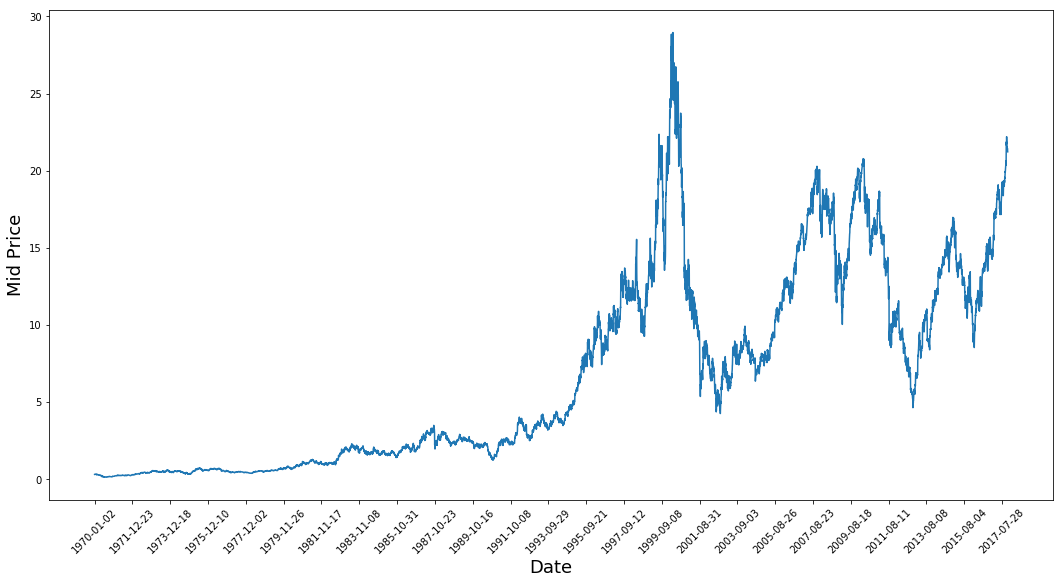

In [77]:
# Data visualization
plt.figure(figsize = (18,9))
plt.plot(range(df.shape[0]),(df['Low']+df['High'])/2.0)
plt.xticks(range(0,df.shape[0],500),df['Date'].loc[::500],rotation=45)
plt.xlabel('Date',fontsize=18)
plt.ylabel('Mid Price',fontsize=18)
plt.show()

In [65]:
# Data Normalization
high_prices = df.loc[:,'High'].as_matrix()
low_prices = df.loc[:,'Low'].as_matrix()
mid_prices = (high_prices+low_prices)/2.0


In [68]:
# Train & Test data split
from sklearn.model_selection import train_test_split
train_data ,test_data = train_test_split(mid_prices,test_size=0.2) 


In [71]:
test_data

array([10.41   , 40.1325 , 18.475  ,  4.605  , 36.69495, 12.015  ,
       50.38   , 42.135  , 51.07   , 48.33   , 44.885  , 39.1025 ,
       28.84   , 43.41   ,  7.03   ,  7.95   ,  4.475  , 40.3775 ,
       10.38   ,  8.76   , 40.2    ,  8.71   ,  2.73   , 11.25   ,
       37.015  , 35.915  , 46.045  , 35.705  , 16.835  , 30.165  ,
       30.7    , 36.0825 , 57.73   ,  5.915  , 35.46   , 40.1724 ,
       46.14   , 30.7    , 11.72   , 52.855  , 35.68   , 47.14   ,
       41.00005, 43.79   , 17.135  ,  5.76   , 41.135  ,  9.14   ,
        8.59   , 43.965  ,  3.29   ,  5.49   ,  9.735  , 60.115  ,
       10.835  , 41.875  ,  9.275  , 43.15   , 45.705  ,  5.31   ,
        7.49   , 36.64425,  3.23   , 36.63   ,  3.835  , 12.865  ,
        9.43   , 49.11   ,  4.945  , 14.36   ,  2.38   , 49.795  ,
       39.9275 , 45.57   , 27.85   ,  9.19   , 24.44505,  7.185  ,
       53.445  , 39.58   , 49.05   , 16.67   ,  9.415  , 35.105  ,
       10.65   , 41.69   , 38.725  , 28.67   ,  4.09   , 46.27

In [73]:
# Scale the data to be between 0 and 1
# When scaling remember! You normalize both test and train data w.r.t training data
# Because you are not supposed to have access to test data
scaler = MinMaxScaler()
train_data = train_data.reshape(-1,1)
test_data = test_data.reshape(-1,1)

In [74]:
test_data

array([[10.41   ],
       [40.1325 ],
       [18.475  ],
       [ 4.605  ],
       [36.69495],
       [12.015  ],
       [50.38   ],
       [42.135  ],
       [51.07   ],
       [48.33   ],
       [44.885  ],
       [39.1025 ],
       [28.84   ],
       [43.41   ],
       [ 7.03   ],
       [ 7.95   ],
       [ 4.475  ],
       [40.3775 ],
       [10.38   ],
       [ 8.76   ],
       [40.2    ],
       [ 8.71   ],
       [ 2.73   ],
       [11.25   ],
       [37.015  ],
       [35.915  ],
       [46.045  ],
       [35.705  ],
       [16.835  ],
       [30.165  ],
       [30.7    ],
       [36.0825 ],
       [57.73   ],
       [ 5.915  ],
       [35.46   ],
       [40.1724 ],
       [46.14   ],
       [30.7    ],
       [11.72   ],
       [52.855  ],
       [35.68   ],
       [47.14   ],
       [41.00005],
       [43.79   ],
       [17.135  ],
       [ 5.76   ],
       [41.135  ],
       [ 9.14   ],
       [ 8.59   ],
       [43.965  ],
       [ 3.29   ],
       [ 5.49   ],
       [ 9.7

In [35]:
# Train the Scaler with training data and smooth data 
smoothing_window_size = 500
for di in range(0,2000,smoothing_window_size):
    scaler.fit(train_data[di:di+smoothing_window_size,:])
    train_data[di:di+smoothing_window_size,:] = scaler.transform(train_data[di:di+smoothing_window_size,:])

# You normalize the last bit of remaining data 
scaler.fit(train_data[di+smoothing_window_size:,:])
train_data[di+smoothing_window_size:,:] = scaler.transform(train_data[di+smoothing_window_size:,:])

In [36]:
train_data = train_data.reshape(-1)

# Normalize test data
test_data = scaler.transform(test_data).reshape(-1)

In [38]:
# Now perform exponential moving average smoothing
# So the data will have a smoother curve than the original ragged data
EMA = 0.0
gamma = 0.1
for ti in range(2568):
  EMA = gamma*train_data[ti] + (1-gamma)*EMA
  train_data[ti] = EMA

# Used for visualization and test purposes
all_mid_data = np.concatenate([train_data,test_data],axis=0)

In [39]:
window_size = 10
N = train_data.size
std_avg_predictions = []
std_avg_x = []
mse_errors = []

for pred_idx in range(window_size,N):
    
    if pred_idx >= N:
        date = dt.datetime.strptime(k, '%Y-%m-%d').date() + dt.timedelta(days=1)
    else:
        date = df.loc[pred_idx,'Date']
        
    std_avg_predictions.append(np.mean(train_data[pred_idx-window_size:pred_idx]))
    mse_errors.append((std_avg_predictions[-1]-train_data[pred_idx])**2)
    std_avg_x.append(date)

print('MSE error for standard averaging: %.5f'%(0.5*np.mean(mse_errors)))

MSE error for standard averaging: 0.00024


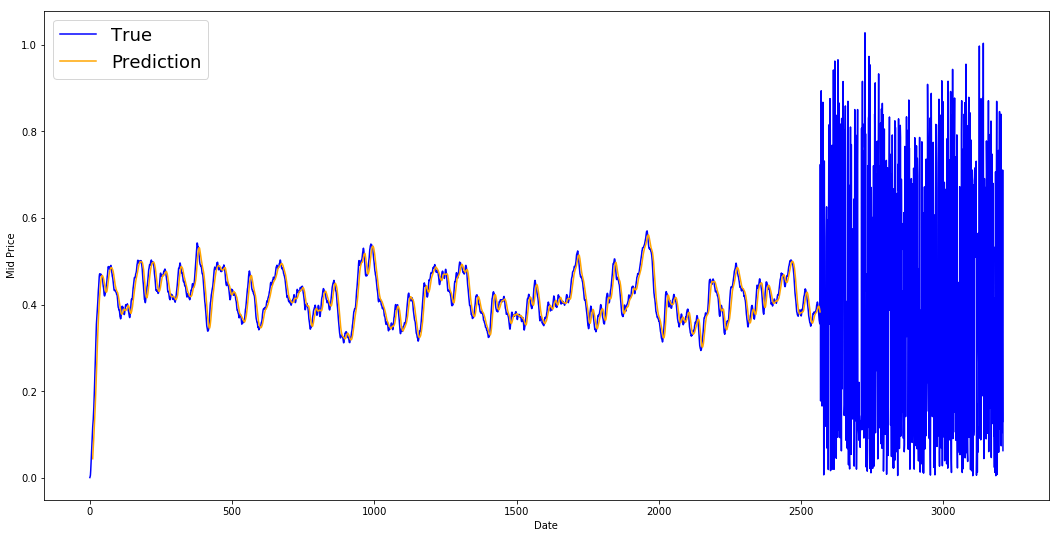

In [40]:

plt.figure(figsize = (18,9))
plt.plot(range(df.shape[0]),all_mid_data,color='b',label='True')
plt.plot(range(window_size,N),std_avg_predictions,color='orange',label='Prediction')
#plt.xticks(range(0,df.shape[0],50),df['Date'].loc[::50],rotation=45)
plt.xlabel('Date')
plt.ylabel('Mid Price')
plt.legend(fontsize=18)
plt.show()

In [41]:
window_size = 10
N = train_data.size

run_avg_predictions = []
run_avg_x = []

mse_errors = []

running_mean = 0.0
run_avg_predictions.append(running_mean)

decay = 0.5

for pred_idx in range(1,N):
    
    running_mean = running_mean*decay + (1.0-decay)*train_data[pred_idx-1]
    run_avg_predictions.append(running_mean)
    mse_errors.append((run_avg_predictions[-1]-train_data[pred_idx])**2)
    run_avg_x.append(date)

print('MSE error for EMA averaging: %.5f'%(0.5*np.mean(mse_errors)))

MSE error for EMA averaging: 0.00004


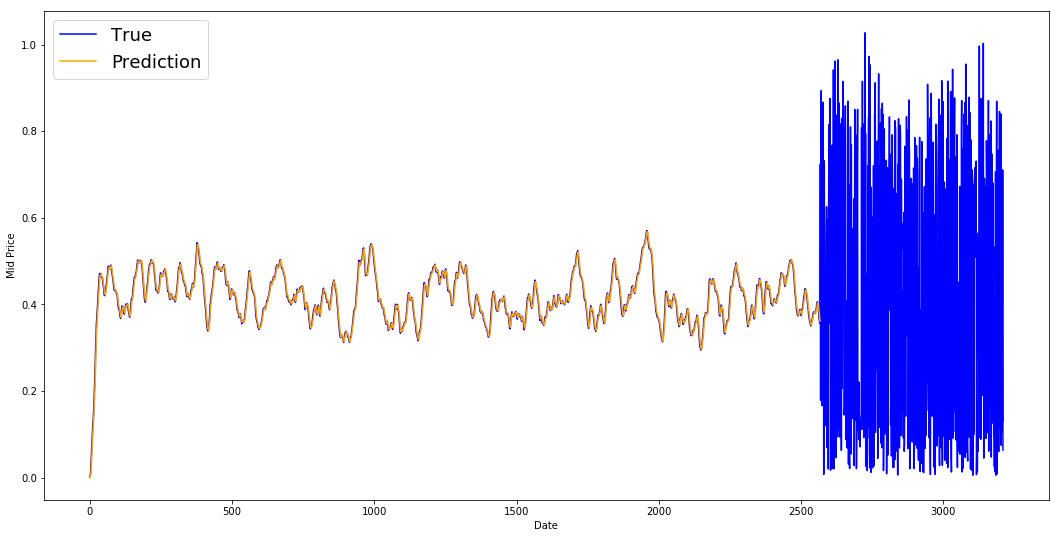

In [42]:

plt.figure(figsize = (18,9))
plt.plot(range(df.shape[0]),all_mid_data,color='b',label='True')
plt.plot(range(0,N),run_avg_predictions,color='orange', label='Prediction')
#plt.xticks(range(0,df.shape[0],50),df['Date'].loc[::50],rotation=45)
plt.xlabel('Date')
plt.ylabel('Mid Price')
plt.legend(fontsize=18)
plt.show()

In [43]:

class DataGeneratorSeq(object):
    
    def __init__(self,prices,batch_size,num_unroll):
        self._prices = prices
        self._prices_length = len(self._prices) - num_unroll
        self._batch_size = batch_size
        self._num_unroll = num_unroll
        self._segments = self._prices_length //self._batch_size
        self._cursor = [offset * self._segments for offset in range(self._batch_size)]

    def next_batch(self):
        
        batch_data = np.zeros((self._batch_size),dtype=np.float32)
        batch_labels = np.zeros((self._batch_size),dtype=np.float32)
        
        for b in range(self._batch_size):
            if self._cursor[b]+1>=self._prices_length:
                #self._cursor[b] = b * self._segments
                self._cursor[b] = np.random.randint(0,(b+1)*self._segments)
                
            batch_data[b] = self._prices[self._cursor[b]]
            batch_labels[b]= self._prices[self._cursor[b]+np.random.randint(1,5)]
            
            self._cursor[b] = (self._cursor[b]+1)%self._prices_length
            
        return batch_data,batch_labels
    
    def unroll_batches(self):
            
        unroll_data,unroll_labels = [],[]
        init_data, init_label = None,None
        for ui in range(self._num_unroll):
            
            data, labels = self.next_batch()    

            unroll_data.append(data)
            unroll_labels.append(labels)

        return unroll_data, unroll_labels
    
    def reset_indices(self):
        for b in range(self._batch_size):
            self._cursor[b] = np.random.randint(0,min((b+1)*self._segments,self._prices_length-1))
        


dg = DataGeneratorSeq(train_data,5,5)
u_data, u_labels = dg.unroll_batches()

for ui,(dat,lbl) in enumerate(zip(u_data,u_labels)):   
    print('\n\nUnrolled index %d'%ui)
    dat_ind = dat
    lbl_ind = lbl
    print('\tInputs: ',dat )
    print('\n\tOutput:',lbl)
    



Unrolled index 0
	Inputs:  [0.00120399 0.41571316 0.40184993 0.3975373  0.40751293]

	Output: [0.01718624 0.40517893 0.39166456 0.4077302  0.41550696]


Unrolled index 1
	Inputs:  [0.00351909 0.41109896 0.39895085 0.4077302  0.4120518 ]

	Output: [0.03186183 0.39789978 0.3911881  0.4157328  0.42135534]


Unrolled index 2
	Inputs:  [0.00687788 0.40934107 0.39852569 0.4130173  0.412002  ]

	Output: [0.05957688 0.38684607 0.39581454 0.42223096 0.4238561 ]


Unrolled index 3
	Inputs:  [0.01718624 0.40517893 0.39581454 0.41458422 0.41550696]

	Output: [0.03186183 0.38684607 0.39049703 0.4241739  0.42295045]


Unrolled index 4
	Inputs:  [0.03186183 0.39789978 0.39166456 0.4131568  0.42135534]

	Output: [0.05957688 0.38684607 0.3911881  0.42223096 0.419054  ]


In [44]:
D = 1 # Dimensionality of the data. Since our data is 1-D this would be 1
num_unrollings = 50 # Number of time steps you look into the future.
batch_size = 50 # Number of samples in a batch
num_nodes = [200,200,150] # Number of hidden nodes in each layer of the deep LSTM stack we're using
n_layers = len(num_nodes) # number of layers
dropout = 0.2 # dropout amount

tf.reset_default_graph() # This is important in case you run this multiple times

In [45]:
# Input data.
train_inputs, train_outputs = [],[]

# You unroll the input over time defining placeholders for each time step
for ui in range(num_unrollings):
    train_inputs.append(tf.placeholder(tf.float32, shape=[batch_size,D],name='train_inputs_%d'%ui))
    train_outputs.append(tf.placeholder(tf.float32, shape=[batch_size,1], name = 'train_outputs_%d'%ui))


In [46]:
lstm_cells = [
    tf.contrib.rnn.LSTMCell(num_units=num_nodes[li],
                            state_is_tuple=True,
                            initializer= tf.contrib.layers.xavier_initializer()
                           )
 for li in range(n_layers)]

drop_lstm_cells = [tf.contrib.rnn.DropoutWrapper(
    lstm, input_keep_prob=1.0,output_keep_prob=1.0-dropout, state_keep_prob=1.0-dropout
) for lstm in lstm_cells]
drop_multi_cell = tf.contrib.rnn.MultiRNNCell(drop_lstm_cells)
multi_cell = tf.contrib.rnn.MultiRNNCell(lstm_cells)

w = tf.get_variable('w',shape=[num_nodes[-1], 1], initializer=tf.contrib.layers.xavier_initializer())
b = tf.get_variable('b',initializer=tf.random_uniform([1],-0.1,0.1))

In [47]:
# Create cell state and hidden state variables to maintain the state of the LSTM
c, h = [],[]
initial_state = []
for li in range(n_layers):
  c.append(tf.Variable(tf.zeros([batch_size, num_nodes[li]]), trainable=False))
  h.append(tf.Variable(tf.zeros([batch_size, num_nodes[li]]), trainable=False))
  initial_state.append(tf.contrib.rnn.LSTMStateTuple(c[li], h[li]))

# Do several tensor transofmations, because the function dynamic_rnn requires the output to be of 
# a specific format. Read more at: https://www.tensorflow.org/api_docs/python/tf/nn/dynamic_rnn
all_inputs = tf.concat([tf.expand_dims(t,0) for t in train_inputs],axis=0)

# all_outputs is [seq_length, batch_size, num_nodes]
all_lstm_outputs, state = tf.nn.dynamic_rnn(
    drop_multi_cell, all_inputs, initial_state=tuple(initial_state),
    time_major = True, dtype=tf.float32)

all_lstm_outputs = tf.reshape(all_lstm_outputs, [batch_size*num_unrollings,num_nodes[-1]])

all_outputs = tf.nn.xw_plus_b(all_lstm_outputs,w,b)

split_outputs = tf.split(all_outputs,num_unrollings,axis=0)

In [48]:
# When calculating the loss you need to be careful about the exact form, because you calculate
# loss of all the unrolled steps at the same time
# Therefore, take the mean error or each batch and get the sum of that over all the unrolled steps

print('Defining training Loss')
loss = 0.0
with tf.control_dependencies([tf.assign(c[li], state[li][0]) for li in range(n_layers)]+
                             [tf.assign(h[li], state[li][1]) for li in range(n_layers)]):
  for ui in range(num_unrollings):
    loss += tf.reduce_mean(0.5*(split_outputs[ui]-train_outputs[ui])**2)

print('Learning rate decay operations')
global_step = tf.Variable(0, trainable=False)
inc_gstep = tf.assign(global_step,global_step + 1)
tf_learning_rate = tf.placeholder(shape=None,dtype=tf.float32)
tf_min_learning_rate = tf.placeholder(shape=None,dtype=tf.float32)

learning_rate = tf.maximum(
    tf.train.exponential_decay(tf_learning_rate, global_step, decay_steps=1, decay_rate=0.5, staircase=True),
    tf_min_learning_rate)

# Optimizer.
print('TF Optimization operations')
optimizer = tf.train.AdamOptimizer(learning_rate)
gradients, v = zip(*optimizer.compute_gradients(loss))
gradients, _ = tf.clip_by_global_norm(gradients, 5.0)
optimizer = optimizer.apply_gradients(
    zip(gradients, v))

print('\tAll done')

Defining training Loss
Learning rate decay operations
TF Optimization operations
	All done


In [49]:
print('Defining prediction related TF functions')

sample_inputs = tf.placeholder(tf.float32, shape=[1,D])

# Maintaining LSTM state for prediction stage
sample_c, sample_h, initial_sample_state = [],[],[]
for li in range(n_layers):
  sample_c.append(tf.Variable(tf.zeros([1, num_nodes[li]]), trainable=False))
  sample_h.append(tf.Variable(tf.zeros([1, num_nodes[li]]), trainable=False))
  initial_sample_state.append(tf.contrib.rnn.LSTMStateTuple(sample_c[li],sample_h[li]))

reset_sample_states = tf.group(*[tf.assign(sample_c[li],tf.zeros([1, num_nodes[li]])) for li in range(n_layers)],
                               *[tf.assign(sample_h[li],tf.zeros([1, num_nodes[li]])) for li in range(n_layers)])

sample_outputs, sample_state = tf.nn.dynamic_rnn(multi_cell, tf.expand_dims(sample_inputs,0),
                                   initial_state=tuple(initial_sample_state),
                                   time_major = True,
                                   dtype=tf.float32)

with tf.control_dependencies([tf.assign(sample_c[li],sample_state[li][0]) for li in range(n_layers)]+
                              [tf.assign(sample_h[li],sample_state[li][1]) for li in range(n_layers)]):  
  sample_prediction = tf.nn.xw_plus_b(tf.reshape(sample_outputs,[1,-1]), w, b)

print('\tAll done')

Defining prediction related TF functions
	All done


In [52]:
epochs = 30
valid_summary = 1 # Interval you make test predictions

n_predict_once = 50 # Number of steps you continously predict for

train_seq_length = train_data.size # Full length of the training data

train_mse_ot = [] # Accumulate Train losses
test_mse_ot = [] # Accumulate Test loss
predictions_over_time = [] # Accumulate predictions

session = tf.InteractiveSession()

tf.global_variables_initializer().run()

# Used for decaying learning rate
loss_nondecrease_count = 0
loss_nondecrease_threshold = 2 # If the test error hasn't increased in this many steps, decrease learning rate

print('Initialized')
average_loss = 0

# Define data generator
data_gen = DataGeneratorSeq(train_data,batch_size,num_unrollings) 

x_axis_seq = []

# Points you start our test predictions from
test_points_seq = np.arange(2568,3500,10).tolist() 

for ep in range(epochs):       
    
    # ========================= Training =====================================
    for step in range(train_seq_length//batch_size):
        
        u_data, u_labels = data_gen.unroll_batches()

        feed_dict = {}
        for ui,(dat,lbl) in enumerate(zip(u_data,u_labels)):            
            feed_dict[train_inputs[ui]] = dat.reshape(-1,1)
            feed_dict[train_outputs[ui]] = lbl.reshape(-1,1)
        
        feed_dict.update({tf_learning_rate: 0.0001, tf_min_learning_rate:0.000001})

        _, l = session.run([optimizer, loss], feed_dict=feed_dict)

        average_loss += l
    
    # ============================ Validation ==============================
    if (ep+1) % valid_summary == 0:

      average_loss = average_loss/(valid_summary*(train_seq_length//batch_size))
      
      # The average loss
      if (ep+1)%valid_summary==0:
        print('Average loss at step %d: %f' % (ep+1, average_loss))
      
      train_mse_ot.append(average_loss)
            
      average_loss = 0 # reset loss
      
      predictions_seq = []
      
      mse_test_loss_seq = []
      
      # ===================== Updating State and Making Predicitons ========================
      for w_i in test_points_seq:
        mse_test_loss = 0.0
        our_predictions = []
        
        if (ep+1)-valid_summary==0:
          # Only calculate x_axis values in the first validation epoch
          x_axis=[]
        
        # Feed in the recent past behavior of stock prices
        # to make predictions from that point onwards
        for tr_i in range(w_i-num_unrollings+1,w_i-1):
          current_price = all_mid_data[tr_i]
          feed_dict[sample_inputs] = np.array(current_price).reshape(1,1)    
          _ = session.run(sample_prediction,feed_dict=feed_dict)
        
        feed_dict = {}
        
        current_price = all_mid_data[w_i-1]
        
        feed_dict[sample_inputs] = np.array(current_price).reshape(1,1)
        
        # Make predictions for this many steps
        # Each prediction uses previous prediciton as it's current input
        for pred_i in range(n_predict_once):

          pred = session.run(sample_prediction,feed_dict=feed_dict)
        
          our_predictions.append(np.asscalar(pred))
        
          feed_dict[sample_inputs] = np.asarray(pred).reshape(-1,1)

          if (ep+1)-valid_summary==0:
            # Only calculate x_axis values in the first validation epoch
            x_axis.append(w_i+pred_i)

          mse_test_loss += 0.5*(pred-all_mid_data[w_i+pred_i])**2
        
        session.run(reset_sample_states)
        
        predictions_seq.append(np.array(our_predictions))
        
        mse_test_loss /= n_predict_once
        mse_test_loss_seq.append(mse_test_loss)
        
        if (ep+1)-valid_summary==0:
          x_axis_seq.append(x_axis)
        
      current_test_mse = np.mean(mse_test_loss_seq)
      
      # Learning rate decay logic
      if len(test_mse_ot)>0 and current_test_mse > min(test_mse_ot):
          loss_nondecrease_count += 1
      else:
          loss_nondecrease_count = 0
      
      if loss_nondecrease_count > loss_nondecrease_threshold :
            session.run(inc_gstep)
            loss_nondecrease_count = 0
            print('\tDecreasing learning rate by 0.5')
      
      test_mse_ot.append(current_test_mse)
      print('\tTest MSE: %.5f'%np.mean(mse_test_loss_seq))
      predictions_over_time.append(predictions_seq)
      print('\tFinished Predictions')

C:\Users\S719789\AppData\Local\Continuum\Anaconda2\lib\site-packages\tensorflow\python\client\session.py:1711: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


Initialized
Average loss at step 1: 0.421451


IndexError: index 3211 is out of bounds for axis 0 with size 3211

In [53]:
InteractiveSession.close()

NameError: name 'InteractiveSession' is not defined

In [50]:
len(mid_prices)


3211

In [ ]:
32

In [30]:
len(test_data)
test_data

array([44.15635, 12.175  , 46.63   , 54.115  , 47.93   , 17.235  ,
       11.485  , 49.71   , 42.74335, 52.55995, 33.005  , 42.30995,
        2.175  , 25.44   , 44.62   , 31.015  , 11.685  ,  8.75   ,
       10.025  , 25.505  ,  9.175  , 34.2    , 38.42   ,  5.805  ,
       29.07   , 33.125  ,  7.395  , 36.69495,  2.895  , 36.25   ,
       49.5    , 22.58   , 41.3629 , 48.11   , 53.0549 , 48.68   ,
        2.745  , 46.275  , 40.505  , 38.71   ,  8.01   , 46.74   ,
        2.945  ,  8.955  , 30.02   ,  4.82   , 56.925  , 11.04   ,
        2.92   , 48.2775 ,  6.95   , 58.135  ,  8.65   , 15.3    ,
        8.985  , 50.825  ,  4.42   , 22.505  , 10.04   , 34.55   ,
       33.74   ,  7.255  , 58.305  ,  8.275  , 39.585  , 35.315  ,
       52.4575 , 43.75   ,  8.985  ,  7.205  ,  9.17   , 49.6    ,
       39.62   , 40.72   ,  5.425  , 50.38   , 42.67675, 13.82   ,
       39.215  , 30.475  , 55.365  , 38.07   , 40.105  , 32.835  ,
       10.21   , 11.605  , 48.817  , 48.51   , 52.065  , 43.19

In [59]:
z = np.array([[1, 2, 3, 4],
         [5, 6, 7, 8],
         [9, 10, 11, 12]])
z.reshape(-1,1)

array([[ 1],
       [ 2],
       [ 3],
       [ 4],
       [ 5],
       [ 6],
       [ 7],
       [ 8],
       [ 9],
       [10],
       [11],
       [12]])

In [20]:
m=np.random.rand(len(mid_prices)) < 0.8

array([False,  True, False, ...,  True,  True,  True])

0

array([20.25 , 19.865, 20.34 , ..., 39.475, 38.715, 37.795])

In [1]:
## Learning Normalization : Reference - https://machinelearningmastery.com/how-to-scale-data-for-long-short-term-memory-networks-in-python/
from pandas import Series
from sklearn.preprocessing import MinMaxScaler
# define contrived series
data = [10.0, 20.0, 30.0, 40.0, 50.0, 60.0, 70.0, 80.0, 90.0, 100.0]
series = Series(data)
print(series)
# prepare data for normalization
values = series.values
values = values.reshape((len(values), 1))
# train the normalization
scaler = MinMaxScaler(feature_range=(0, 1))
scaler = scaler.fit(values)
print('Min: %f, Max: %f' % (scaler.data_min_, scaler.data_max_))
# normalize the dataset and print
normalized = scaler.transform(values)
print(normalized)
# inverse transform and print
inversed = scaler.inverse_transform(normalized)
print(inversed)

0     10.0
1     20.0
2     30.0
3     40.0
4     50.0
5     60.0
6     70.0
7     80.0
8     90.0
9    100.0
dtype: float64
Min: 10.000000, Max: 100.000000
[[0.        ]
 [0.11111111]
 [0.22222222]
 [0.33333333]
 [0.44444444]
 [0.55555556]
 [0.66666667]
 [0.77777778]
 [0.88888889]
 [1.        ]]
[[ 10.]
 [ 20.]
 [ 30.]
 [ 40.]
 [ 50.]
 [ 60.]
 [ 70.]
 [ 80.]
 [ 90.]
 [100.]]
